# Atmospheric CO2

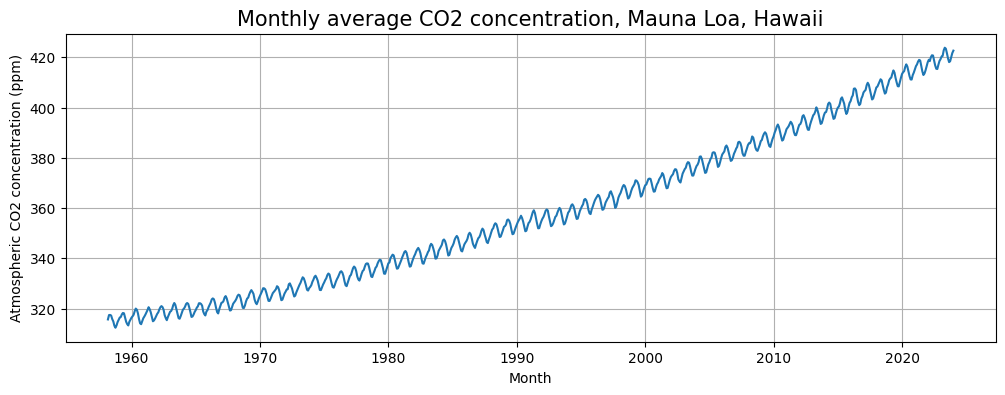

In [48]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_co2 = pd.read_csv("data/monthly_in_situ_co2_mlo.csv")
df_co2["date"] = pd.to_datetime(df_co2["Yr"].astype(str) + "-"
    + df_co2["Mn"].astype(str))
date = np.array(df_co2["date"], dtype=np.datetime64)
co2 = np.array(df_co2["CO2"], dtype=np.float32)

plt.figure(figsize=(12, 4))
g = sns.lineplot(x=date, y=co2)
g.set_xlabel(xlabel="Month")
g.set_ylabel(ylabel="Atmospheric CO2 concentration (ppm)")
g.set_title(label="Monthly average CO2 concentration, Mauna Loa, Hawaii",
    fontsize=15)
g.grid(visible=True)
plt.show()

I0000 00:00:1713963324.738109    3899 service.cc:145] XLA service 0x1f7c3700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713963324.738149    3899 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
W0000 00:00:1713963324.905798    3899 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/split_seed/sanitize_seed/seed
I0000 00:00:1713963346.604994    3899 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


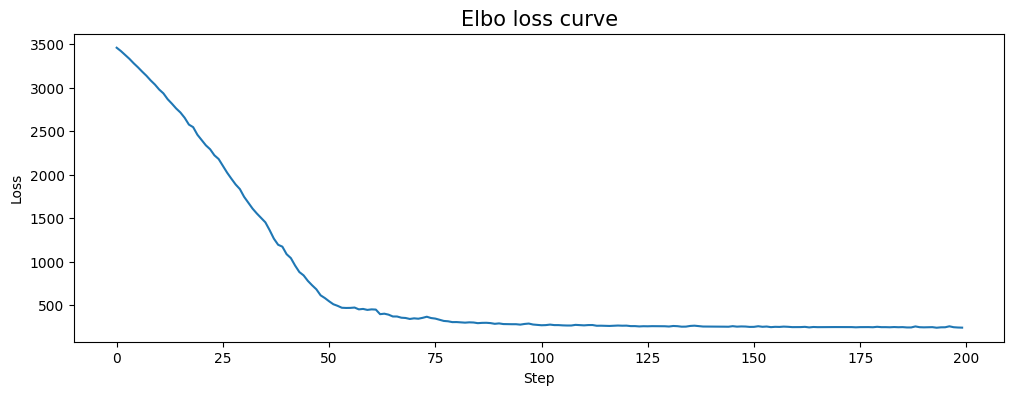

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import tensorflow_probability as tfp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def build_model(ts):
    trend = tfp.sts.LocalLinearTrend(observed_time_series=ts)
    seasonal = tfp.sts.Seasonal(num_seasons=12,
        observed_time_series=ts)
    model = tfp.sts.Sum(components=[trend, seasonal],
        observed_time_series=ts)
    return model

num_forecast = 120
co2_train = co2[:-num_forecast]
co2_model = build_model(ts=co2_train)

variational_posterior = tfp.sts.build_factored_surrogate_posterior(
    model=co2_model)

loss = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=co2_model.joint_distribution(
            observed_time_series=co2_train).log_prob,
        surrogate_posterior=variational_posterior,
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
        num_steps=200, jit_compile=True)

plt.figure(figsize=(12, 4))
g = sns.lineplot(x=np.arange(loss.shape[0]), y=loss)
g.set_xlabel(xlabel="Step")
g.set_ylabel(ylabel="Loss")
g.set_title(label="Elbo loss curve", fontsize=15)
g.grid(visible=True)
plt.show()

Inferred parameters:
observation_noise_scale: 0.1696+/-0.0062
LocalLinearTrend/_level_scale: 0.1603+/-0.0150
LocalLinearTrend/_slope_scale: 0.0102+/-0.0017
Seasonal/_drift_scale: 0.0404+/-0.0047


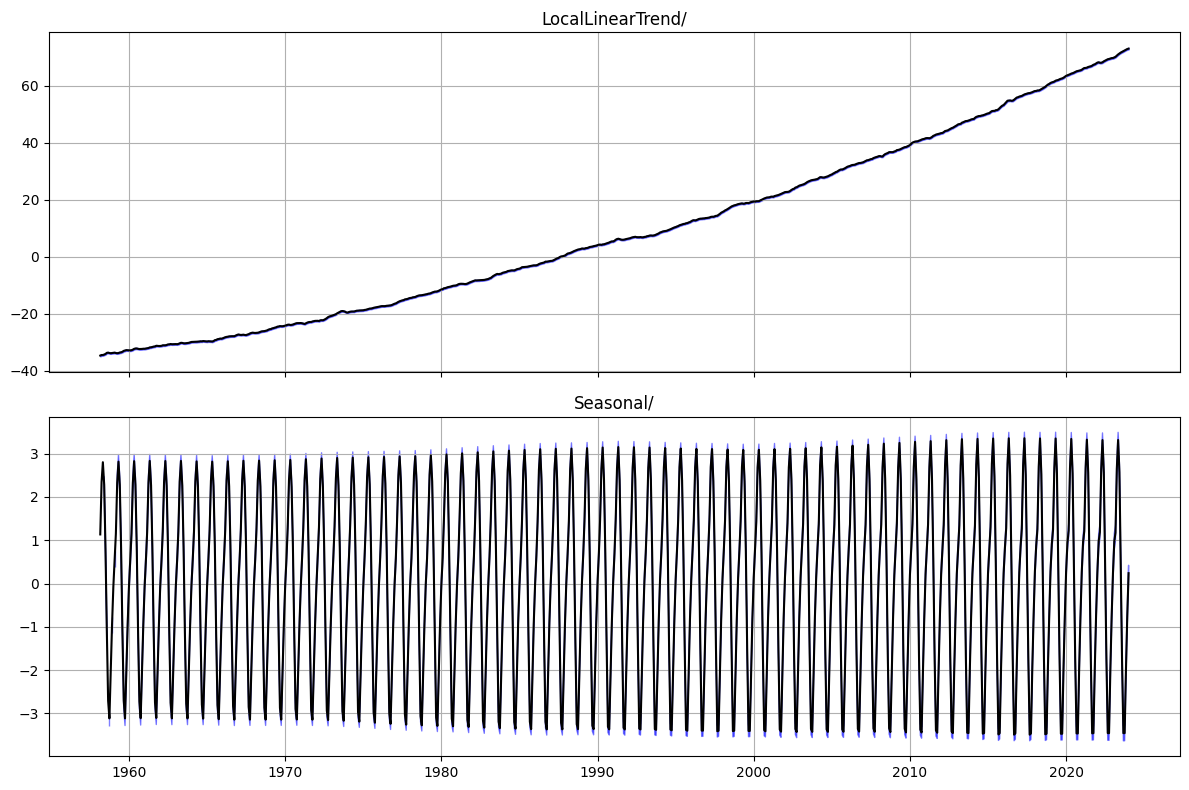

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import tensorflow_probability as tfp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

q_samples = variational_posterior.sample(sample_shape=50)
print("Inferred parameters:")
for param in co2_model.parameters:
    print("{0}: {1:.4f}+/-{2:.4f}".format(
        param.name,
        np.mean(q_samples[param.name], axis=0),
        np.std(q_samples[param.name], axis=0)
    ))

component_dists = tfp.sts.decompose_by_component(
    model=co2_model,
    observed_time_series=co2,
    parameter_samples=q_samples
)

component_means, component_stds = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
for ax, c in zip(axes, component_means.keys()):
    mean, std = component_means[c], component_stds[c]
    g = sns.lineplot(ax=ax, x=date, y=mean, color="black")
    g.fill_between(x=date, y1=mean+2*std, y2=mean-2*std,
        color="blue", alpha=0.5)
    g.set_title(label=c)
    g.grid(visible=True)
fig.tight_layout()
plt.show()

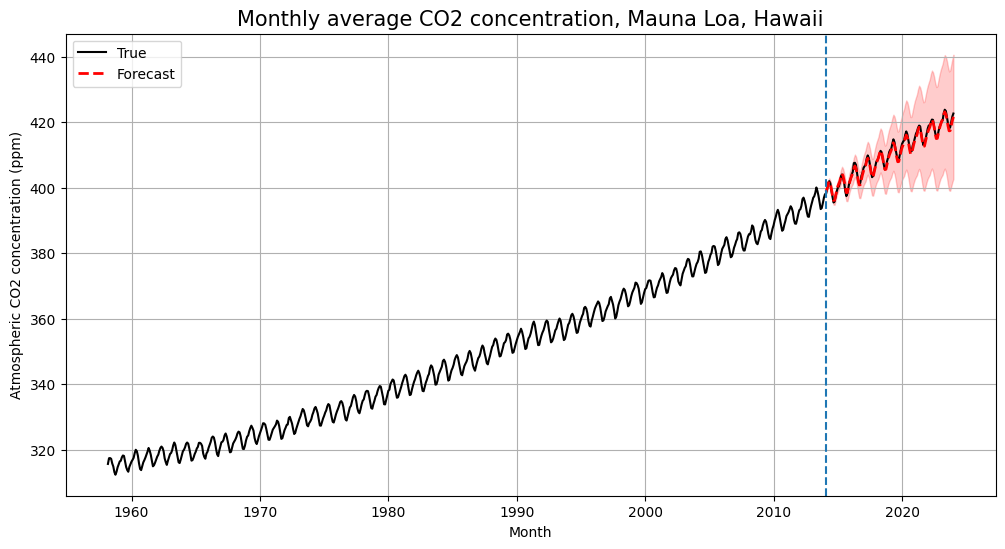

In [50]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import tensorflow_probability as tfp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

forecast_dist = tfp.sts.forecast(
    model=co2_model,
    observed_time_series=co2_train,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast
)
forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean()[..., 0],
    forecast_dist.stddev()[..., 0],
    forecast_dist.sample(10).numpy()[..., 0]
)

plt.figure(figsize=(12, 6))
g = sns.lineplot(x=date, y=co2, color="black", label="True")
g = sns.lineplot(x=date[-num_forecast:], y=forecast_mean,
    lw=2, ls="--",  color="red", label="Forecast")
g.fill_between(x=date[-num_forecast:],
    y1=forecast_mean+2*forecast_scale,
    y2=forecast_mean-2*forecast_scale,
    color="red", alpha=0.2)
g.set_xlabel(xlabel="Month")
g.set_ylabel(ylabel="Atmospheric CO2 concentration (ppm)")
g.set_title(label="Monthly average CO2 concentration, Mauna Loa, Hawaii",
    fontsize=15)
g.axvline(date[-num_forecast], linestyle="--")
g.grid(visible=True)
g.legend(loc="upper left")
plt.show()